# AE + t-SNE

AutoEncoder는 주로 t-SNE이와 같은 neighborhood에 대한 성질을 유지하는 고전적 차원 축소 기법과 함께 사용된다고 한다.

- t-SNE(t-distributed Stochastic Neighbor Embedding)란?

고차원 공간에서 데이터 포인트들 간의 상대적 거리를 저차원 공간에서 최대한 보존하려는 축소 기법이다.

t-SNE는 고차원 데이터의 두 점 사이 유사성을 가우시안 분포로 표현하고, 저차원 공간에서는 t-분포를 사용해 유사성을 모델링한다. <br>
이후, 고차원과 저차원 간의 유사성 분포 차이를 KL Divergence로 최소화하여 국소적 관계를 보존하는 차원 축소를 수행한다.
<p style="color:gray;">시간이 굉장히 많이 걸린다.</p>

- AE 모델 선언과 학습 by MNIST

In [1]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

# 오토인코더 모델
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim=3):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 하이퍼파라미터
batch_size = 64
learning_rate = 0.001
num_epochs = 20
latent_dim = 12

# 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# 모델, 손실 함수, 최적화기 정의
model = AutoEncoder(latent_dim)
model.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# 모델 학습
for epoch in range(15):
    for img, _ in train_loader:
        img = img.view(-1, 28*28)

        optimizer.zero_grad()

        output = model(img)
        loss = criterion(img, output)
        loss.backward()
        optimizer.step()

encoded = model.encoder(train_dataset.data.view(-1,28*28).float()).detach().numpy()
labels = train_dataset.targets.detach().numpy()

In [2]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne_2D = tsne.fit_transform(encoded)

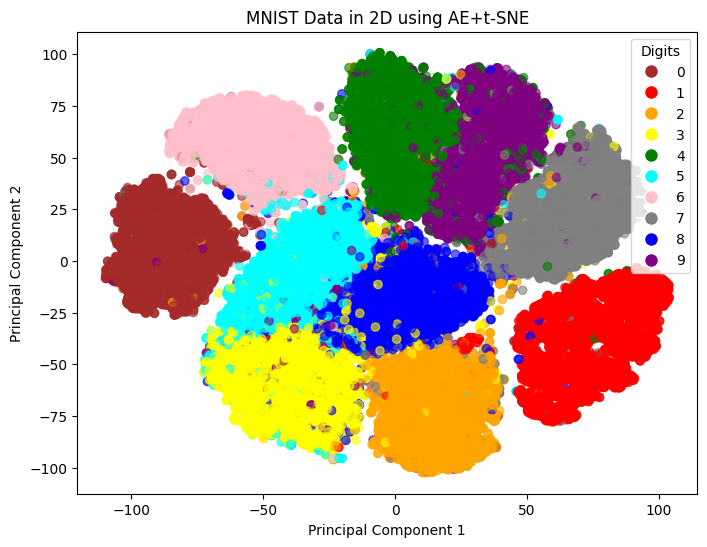

In [3]:
# 색상 설정: 빨주노초파남보
colors = ['brown', 'red', 'orange', 'yellow', 'green', 'cyan', 'pink', 'grey' , 'blue', 'purple']
color_map = [colors[label] for label in labels]

# 결과 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne_2D[:, 0], X_tsne_2D[:, 1], c=color_map, alpha=0.6)

# 범례 추가
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i in range(10)]
plt.legend(legend_labels, range(10), title='Digits', loc='upper right')

plt.title('MNIST Data in 2D using AE+t-SNE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
import pandas as pd
import plotly.express as px

tsne_3d = TSNE(n_components=3, random_state=42)
X_tsne_3D = tsne_3d.fit_transform(encoded)

df = pd.DataFrame(X_tsne_3D, columns=['C1', 'C2', 'C3'])
df['Label'] = labels

# 3D 산점도 생성
fig = px.scatter_3d(df, x='C1', y='C2', z='C3', color='Label', 
                    title='AE+t-SNE of MNIST Dataset (3D)', 
                    labels={'C1': 'Component 1', 
                            'C2': 'Component 2', 
                            'C3': 'Component 3'},
                    color_continuous_scale=px.colors.sequential.Viridis)

# 시각화
fig.show()

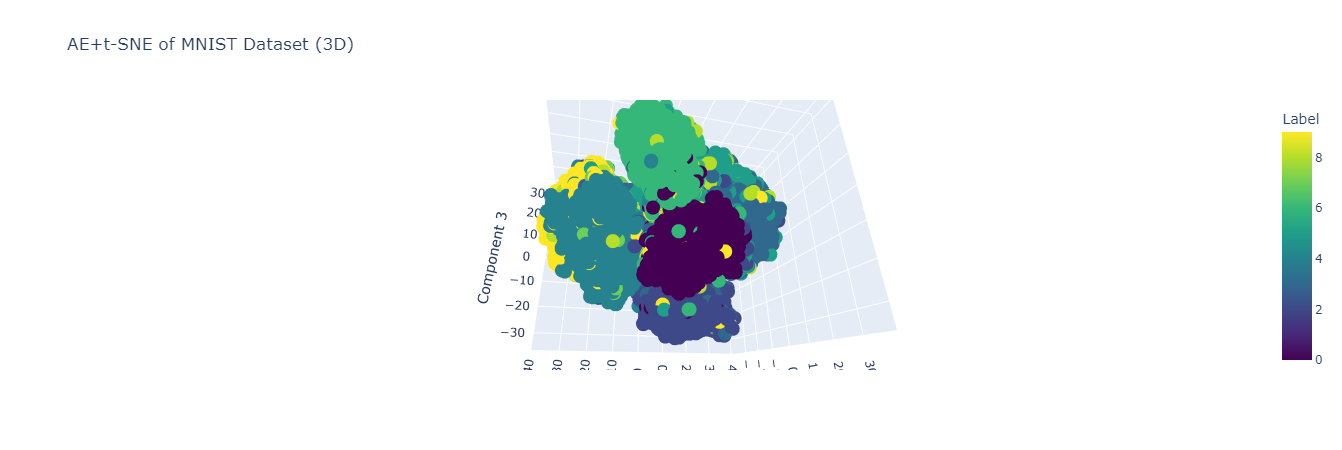

In [1]:
from IPython.display import Image
Image('ae_tsne_3d.png')

# AutoEncoder + Neighborhood Model(t-SNE) 해석

고차원의 데이터를 저차원으로 변환할 때 manifold에 나타나는 거리 개념이 모호해질 수 있다.<br>
따라서 이러한 고차원 데이터의 복잡한 특징을 딥뉴럴넷을 사용하는 AutoEncoder를 통해서 먼저 중간 차원으로 변환한다. <br>
이렇게 변환된 데이터의 manifold는 복잡한 데이터의 거리에 대한 특징이 잘 반영된다고 이해할 수 있다. <br>
정확히 말하면 AutoEncoder는 복잡한 거리 개념을 잘 반영하지만 국소적인 거리 개념의 반영은 잘 수행하지 않는다.<br>
이 문제를 해결하기 위해 거리기반의 차원 축소 기법인 t-SNE를 사용하여 저차원으로 데이터를 축소하면 잘 구분되는 scatter를 그림을 확인할 수 있었다.<br>

정리하자면 AE는 복잡한 데이터의 전반적인 데이터 구조를 학습하고 t-SNE는 이러한 구조 속에서 국소적인 거리정보를 보존하며 차원을 축소하게 된다.